# Prediksi harga apartemen di Jakarta

**Import Library**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

###  Data Understanding

In [2]:
df = pd.read_csv('dataset_apartemen_pinhome.csv')

**Insight**

Dataset yang digunakan dalam proyek ini diperoleh melalui proses web scraping dari situs Pinhome.id [https://www.pinhome.id/]. Dalam proyek ini, data difokuskan hanya pada apartemen di wilayah Jakarta, karena memiliki volume data yang cukup besar dan relevansi yang tinggi terhadap kebutuhan prediksi harga properti di kawasan urban. Data yang dikumpulkan mencakup informasi seperti harga, lokasi (kelurahan, kecamatan, kota), luas bangunan, jumlah kamar tidur, status kepemilikan (Hak Guna), dan estimasi harga per meter persegi.

In [3]:
df.shape

(3993, 8)

**Insight**
- 3993 baris (rows) → Ini menunjukkan jumlah entri atau sampel data.

- 8 kolom (columns) → Ini menunjukkan jumlah fitur atau variabel yang tersedia untuk setiap entri.

In [4]:
df.head()

,Harga,Kelurahan,Kecamatan,Kota,Kamar Tidur,Luas Bangunan,Hak Guna,Harga per m2
0,"Rp779,6 Jt - Rp987,5 Jt",Kel. Pulo Gadung,Kec. Pulogadung (Pulo Gadung),Kota Jakarta Timur,2 Kamar Tidur,Luas Bangunan 42m,Sertifikat Hak Milik,"Rp18,6 Jt/m² - Rp23,5 Jt/m²"
1,"Rp1,5 M - Rp5,1 M",Kel. Cilandak Timur,Kec. Pasar Minggu,Kota Jakarta Selatan,1-3 Kamar Tidur,Luas Bangunan 32-107m,Sertifikat Hak Milik,"Rp14,4 Jt/m² - Rp162 Jt/m²"
2,Rp868 Jt - Rp1 M,Kel. Kelapa Gading Timur,Kec. Kelapa Gading,Kota Jakarta Utara,2 Kamar Tidur,Luas Bangunan 42m,Hak Guna Bangunan,"Rp20,7 Jt/m² - Rp24 Jt/m²"
3,"Rp770 Jt - Rp1,7 M",Kel. Ulujami,Kec. Pesanggrahan,Kota Jakarta Selatan,1-2 Kamar Tidur,Luas Bangunan 25-52m,Hak Guna Bangunan,"Rp14,8 Jt/m² - Rp70,5 Jt/m²"
4,"Rp840 Jt - Rp1,1 M",Kel. Semanan,Kec. Kalideres,Kota Jakarta Barat,6 Kamar Tidur,Luas Bangunan 48m,NaN,"Rp17,5 Jt/m² - Rp22,9 Jt/m²"


**Insight**
- Harga dan Luas Berbentuk Rentang

 - Kolom Harga, Luas Bangunan, dan Harga per m² umumnya dalam bentuk rentang, sehingga perlu dipisahkan menjadi nilai minimum dan maksimum.

- Fitur Kategorikal Lokasi

  - Kombinasi Kelurahan, Kecamatan, dan Kota bisa digunakan untuk membuat fitur lokasi secara hierarkis.

  - Bisa digunakan untuk clustering wilayah atau analisis distribusi harga.

- Data Belum Siap Langsung untuk Model

  - Semua fitur berbentuk string gabungan (text + angka + satuan)

  - Ada Missing Values

  - Contohnya, kolom Hak Guna ada nilai kosong (NaN)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Harga          3993 non-null   object
 1   Kelurahan      3993 non-null   object
 2   Kecamatan      3993 non-null   object
 3   Kota           3353 non-null   object
 4   Kamar Tidur    3992 non-null   object
 5   Luas Bangunan  3883 non-null   object
 6   Hak Guna       2421 non-null   object
 7   Harga per m2   3993 non-null   object
dtypes: object(8)
memory usage: 249.7+ KB


**Insight**
- Terdiri dari 3993 baris dan 8 kolom, seluruhnya bertipe teks (object).

- Kolom Harga, Kelurahan, Kecamatan, dan Harga per m2 tidak memiliki missing value.

- Kolom Kota, Kamar Tidur, Luas Bangunan, dan Hak Guna memiliki data yang hilang, terutama Hak Guna (~40% missing).

- Nilai numerik masih dalam format teks, perlu pembersihan dan konversi tipe data.

- Dataset butuh preprocessing sebelum bisa digunakan untuk analisis atau modeling.

In [6]:
df.describe(include='all')

,Harga,Kelurahan,Kecamatan,Kota,Kamar Tidur,Luas Bangunan,Hak Guna,Harga per m2
count,3993,3993,3993,3353,3992,3883,2421,3993
unique,386,204,45,5,55,284,4,572
top,"Rp1,2 M",Kel. Tanjung Duren Selatan,Kec. Setiabudi (Setia Budi),Kota Jakarta Selatan,2 Kamar Tidur,Luas Bangunan 35m,Sertifikat Hak Milik,"Rp16,7 Jt/m²"
freq,154,161,390,1266,1911,173,1092,71


**Insight**
- Harga: Ada 386 variasi harga, dengan nilai paling sering adalah Rp1,2 M (154 unit).

- Kelurahan & Kecamatan: Data mencakup 204 kelurahan dan 45 kecamatan, dengan Kel. Tanjung Duren Selatan dan Kec. Setiabudi paling dominan.

- Kota: Terdapat 5 kota administratif, dengan Jakarta Selatan paling banyak (1266 unit).

- Kamar Tidur: Variasi kamar tidur mencapai 55 kategori unik, namun 2 Kamar Tidur paling umum (1911 unit).

- Luas Bangunan: Terdapat 284 nilai unik, yang paling sering adalah 35m² (173 unit).

- Hak Guna: Mayoritas apartemen memiliki Sertifikat Hak Milik (1092 unit dari 2421 data yang tersedia).

- Harga per m²: Memiliki 572 nilai unik, dengan yang paling umum adalah Rp16,7 Jt/m² (71 unit).

In [7]:
df.isnull().sum()

,0
Harga,0
Kelurahan,0
Kecamatan,0
Kota,640
Kamar Tidur,1
Luas Bangunan,110
Hak Guna,1572
Harga per m2,0


**Insight**

Terdapat beberapa kolom dengan nilai yang hilang. Kolom Kota memiliki sekitar 16% data yang kosong, sementara kolom Hak Guna memiliki jumlah missing value yang cukup tinggi, yaitu sekitar 39%. Kolom Kamar Tidur dan Luas Bangunan memiliki missing value dalam jumlah kecil.







**Univariate Visualisasi**

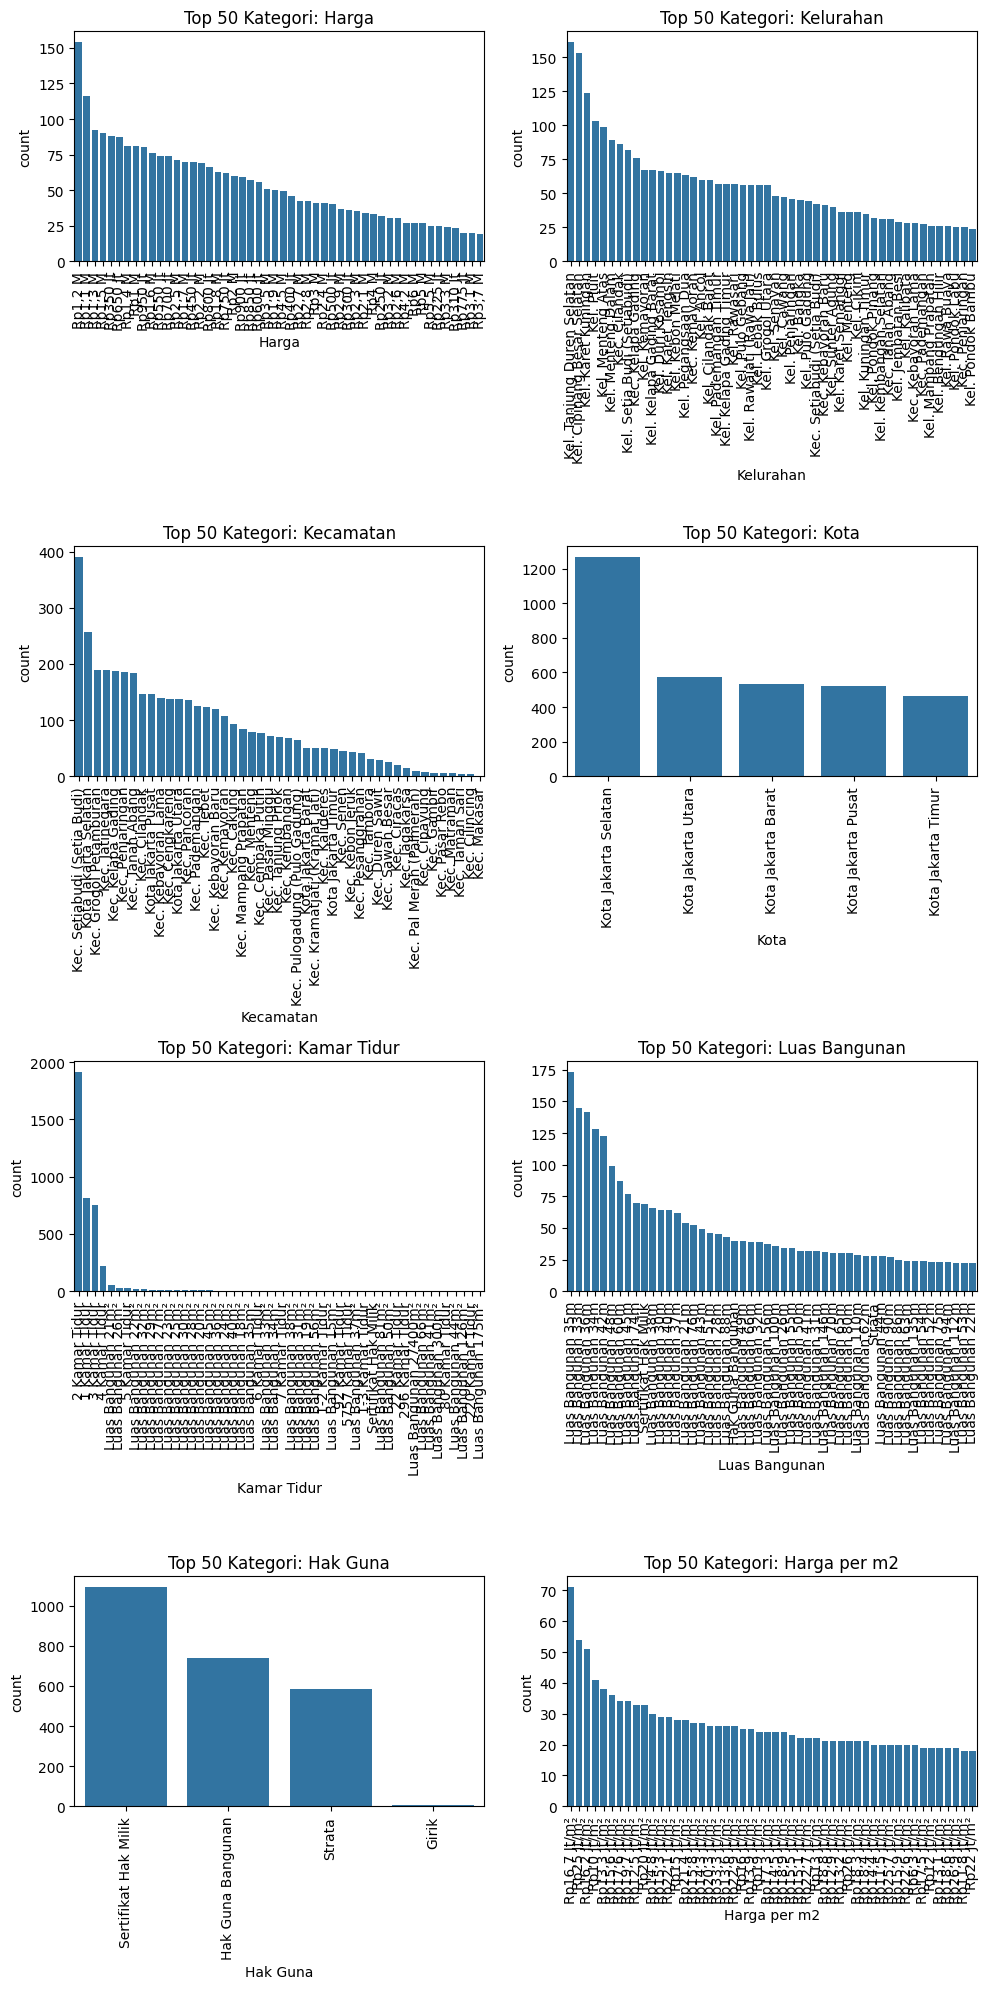

In [8]:
top_n = 50
n_cols = 2
n_rows = (len(df.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    order = df[col].value_counts().head(top_n).index
    sns.countplot(data=df, x=col, order=order, ax=ax)
    ax.set_title(f"Top {top_n} Kategori: {col}")
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

**Insight**
- Harga & Harga per m2
  Masih dalam format teks dengan satuan “M” (Miliar) dan “Jt” (Juta), perlu konversi ke format numerik agar bisa dianalisis secara kuantitatif.

- Kelurahan
  Terdapat banyak kesalahan data berupa pencampuran dengan nama kecamatan, menyebabkan ketidakkonsistenan dan kesalahan lokasi.

- Kecamatan
  Beberapa data di kolom ini sebenarnya adalah nama kota, bukan kecamatan, yang berarti ada pergeseran data antar kolom.

- Kota
  Ada kemungkinan data kota tercampur di kolom kecamatan.

- Kamar Tidur
  Nilai unik sangat banyak dan ada data yang salah, seperti tercampurnya data luas bangunan di sini, menunjukkan kesalahan input.

- Luas Bangunan
  Data berformat campuran antara angka dan teks (misal “Luas Bangunan 35m”), perlu pembersihan untuk menjadi nilai numerik yang valid.

- Hak Guna
  Tipe hak guna cukup konsisten dengan 4 kategori utama.

### Data Preparation

**Filter Baris Valid**

In [9]:
def filter_baris_valid(df):
    def is_valid_harga(x): return isinstance(x, str) and "Rp" in x
    def is_valid_kelurahan(x): return isinstance(x, str) and x.strip().startswith("Kel.")
    def is_valid_kecamatan(x): return isinstance(x, str) and x.strip().startswith("Kec.")
    def is_valid_kota(x): return isinstance(x, str) and x.strip().startswith("Kota")
    def is_valid_kamar_tidur(x): return isinstance(x, str) and "Kamar Tidur" in x
    def is_valid_luas_bangunan(x): return isinstance(x, str) and "Luas Bangunan" in x and "m" in x
    def is_valid_hak_guna(x):
        if not isinstance(x, str): return False
        x = x.lower()
        return any(word in x for word in ["hak milik", "hak guna", "girik", "strata"])
    def is_valid_harga_per_m2(x): return isinstance(x, str) and "Rp" in x and "/m²" in x

    mask = (
        df["Harga"].apply(is_valid_harga) &
        df["Kelurahan"].apply(is_valid_kelurahan) &
        df["Kecamatan"].apply(is_valid_kecamatan) &
        df["Kota"].apply(is_valid_kota) &
        df["Kamar Tidur"].apply(is_valid_kamar_tidur) &
        df["Luas Bangunan"].apply(is_valid_luas_bangunan) &
        df["Hak Guna"].apply(is_valid_hak_guna) &
        df["Harga per m2"].apply(is_valid_harga_per_m2)
    )
    return df[mask].reset_index(drop=True)

**Insight**

Fungsi filter_baris_valid(df) ini digunakan untuk memilih hanya baris data yang formatnya benar dan konsisten di semua kolom utama (Harga, Kelurahan, Kecamatan, Kota, Kamar Tidur, Luas Bangunan, Hak Guna, Harga per m2).

Tujuannya untuk membersihkan data dari entri yang salah, kosong, atau data yang salah kolom (misalnya kamar tidur berisi luas bangunan). Hasilnya adalah dataset yang lebih valid dan siap diproses lebih lanjut, tapi berisiko menghilangkan banyak data jika formatnya tidak konsisten.

**Fungsi Ekstraksi dan Encoding**

In [10]:
def clean_rupiah(value):
    if pd.isnull(value): return np.nan
    value = value.replace('Rp', '').replace('Jt', 'e6').replace('M', 'e9')
    try:
        return np.mean([eval(re.sub(r'[^0-9.e]', '', x)) for x in value.split('-')])
    except:
        return np.nan

def extract_m2(value):
    if pd.isnull(value): return np.nan
    nums = re.findall(r'\d+', str(value))
    return np.mean([float(n) for n in nums]) if nums else np.nan

def extract_kamar_tidur(value):
    if pd.isnull(value): return np.nan
    nums = re.findall(r'\d+', str(value))
    return np.mean([float(n) for n in nums]) if nums else np.nan

def frequency_encoding(df, column):
    freq_map = df[column].value_counts() / len(df)
    return df[column].map(freq_map)

**Insight**

Fungsi-fungsi ini membersihkan data harga, luas bangunan, dan kamar tidur dari format teks menjadi angka yang bisa diproses. clean_rupiah konversi harga dari format “Rp”, “Jt”, dan “M” ke angka, extract_m2 dan extract_kamar_tidur ambil angka dari teks, dan frequency_encoding ubah kategori menjadi angka berdasarkan frekuensi kemunculannya di data.

**Preprocessing Pipeline**

In [11]:
def preprocess_apartment_data(df):
    # Filter baris yang valid
    df = filter_baris_valid(df)

    # Ekstraksi numerik
    df['Harga (Rp)'] = df['Harga'].apply(clean_rupiah)
    df['Luas (m2)'] = df['Luas Bangunan'].apply(extract_m2)
    df['Kamar Tidur (n)'] = df['Kamar Tidur'].apply(extract_kamar_tidur)
    df['Harga per m2 (estimasi)'] = df['Harga (Rp)'] / df['Luas (m2)']

    # Filter logis tambahan
    df = df[df['Kamar Tidur (n)'] <= 10]

    # Imputasi nilai hilang
    df['Kota'] = df['Kota'].fillna(df['Kota'].mode()[0])
    df['Hak Guna'] = df['Hak Guna'].fillna(df['Hak Guna'].mode()[0])
    df['Luas (m2)'] = df['Luas (m2)'].fillna(df['Luas (m2)'].median())
    df['Kamar Tidur (n)'] = df['Kamar Tidur (n)'].fillna(df['Kamar Tidur (n)'].median())

    # Frequency encoding
    df['Kelurahan_Freq'] = frequency_encoding(df, 'Kelurahan')
    df['Kecamatan_Freq'] = frequency_encoding(df, 'Kecamatan')
    df['Kota_Freq'] = frequency_encoding(df, 'Kota')
    df['Hak Guna_Freq'] = frequency_encoding(df, 'Hak Guna')

    return df

**Insight**
- Filter baris valid

  Memilih baris data yang memenuhi kriteria valid tertentu agar data bersih dan konsisten.

- Ekstraksi nilai numerik

  - Mengonversi kolom Harga dari format string ke angka rupiah.

  - Mengambil nilai luas bangunan (m2) dari kolom teks.

  - Mengambil jumlah kamar tidur dari kolom teks.

  - Menghitung estimasi harga per meter persegi (Harga (Rp) dibagi Luas (m2)).

- Filter logis tambahan

  Menghapus baris dengan kamar tidur lebih dari 10 sebagai data yang tidak wajar.

- Imputasi nilai hilang

  - Mengisi nilai kosong di kolom kategori (Kota, Hak Guna) dengan modus (nilai paling sering muncul).

  - Mengisi nilai kosong di kolom numerik (Luas (m2), Kamar Tidur (n)) dengan median (nilai tengah).

- Frequency encoding
  Membuat fitur baru berdasarkan frekuensi kemunculan setiap kategori di kolom Kelurahan, Kecamatan, Kota, dan Hak Guna. Ini membantu mengubah data kategori menjadi numerik yang dapat digunakan model.


In [12]:
df = preprocess_apartment_data(df)

**Visualisasi Distribusi Fitur Numerik**

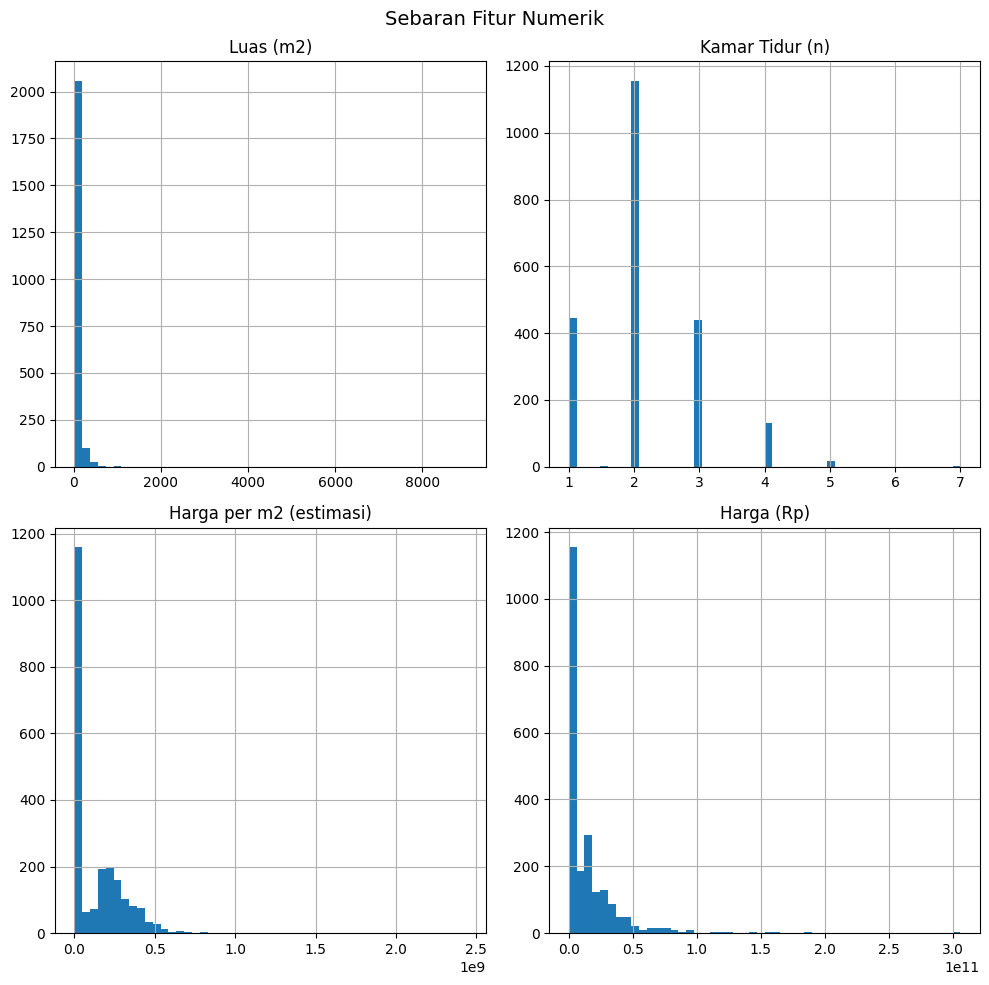

In [13]:
numeric_features = ['Luas (m2)', 'Kamar Tidur (n)', 'Harga per m2 (estimasi)', 'Harga (Rp)']
df[numeric_features].hist(bins=50, figsize=(10, 10))
plt.suptitle('Sebaran Fitur Numerik', fontsize=14)
plt.tight_layout()
plt.show()

**Insight**

- Luas (m²)
  - Mayoritas apartemen memiliki luas di bawah 200 m².
  - Distribusi sangat tidak merata dengan beberapa unit memiliki luas ekstrem di atas 2.000 m² hingga lebih dari 8.000 m².

- Kamar Tidur (n)
  - Jumlah kamar tidur paling umum adalah 2, disusul 1 dan 3 kamar.
  - Jumlah unit dengan lebih dari 4 kamar sangat sedikit.

- Harga per m² (estimasi)
  - Sebaran didominasi oleh harga per m² di bawah 300 juta.
  - Terdapat nilai-nilai sangat tinggi hingga lebih dari 2,5 miliar per m².

- Harga (Rp)
  - Sebagian besar apartemen memiliki harga total di bawah 1 miliar rupiah.
  - Distribusi sangat tidak merata, dengan harga tertinggi mencapai hampir 30 miliar rupiah.



**Visualisasi Distribusi Fitur Kategorikal**

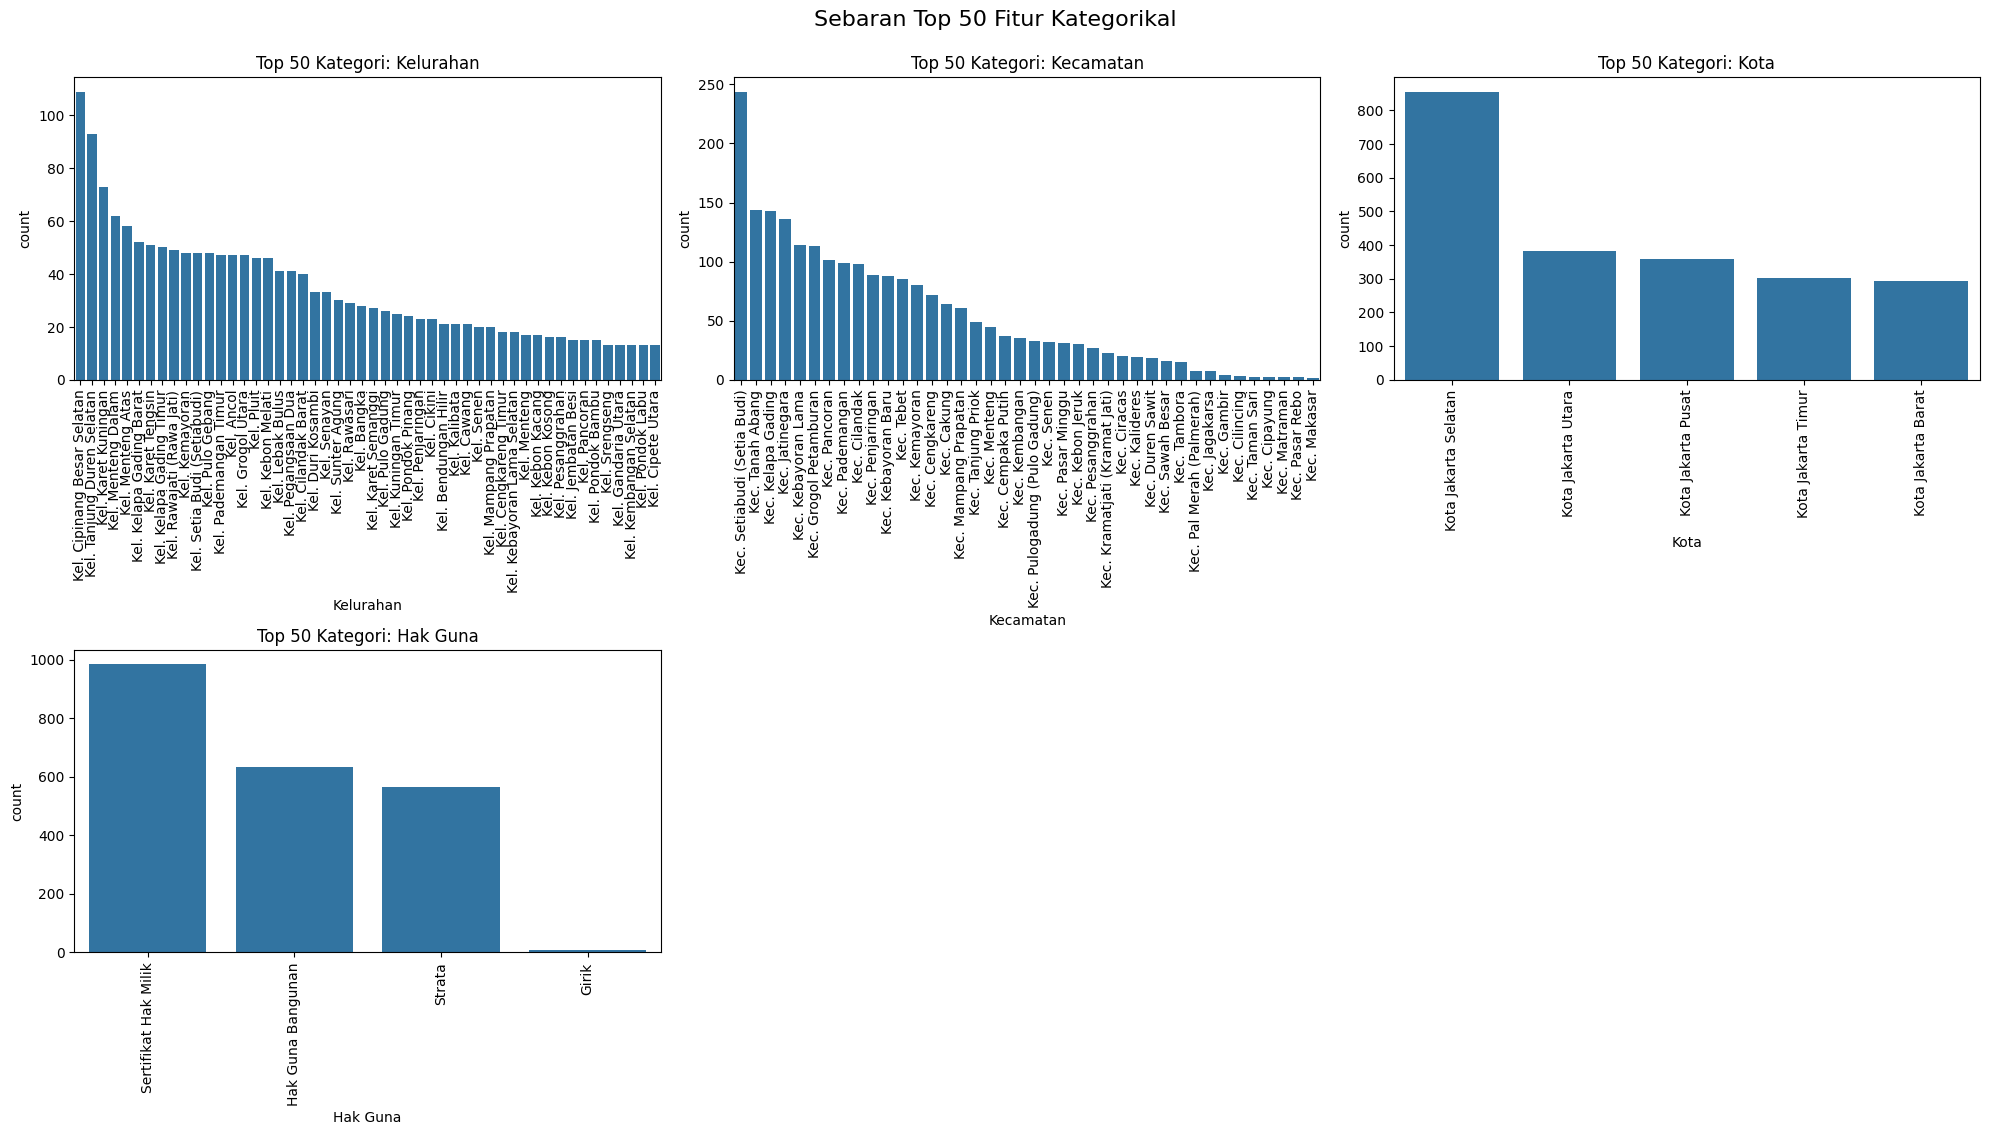

In [14]:
categorical_features = ['Kelurahan', 'Kecamatan', 'Kota', 'Hak Guna']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    top_50 = df[feature].value_counts().index[:50]
    sns.countplot(data=df, x=feature, order=top_50, ax=axes[i])
    axes[i].set_title(f'Top 50 Kategori: {feature}')
    axes[i].tick_params(axis='x', rotation=90)

# Hapus subplot kosong jika ada
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Sebaran Top 50 Fitur Kategorikal', fontsize=16, y=1.02)
plt.show()

**Insight**

- Kelurahan
  - Sebaran cukup beragam, tetapi Kel. Cipinang Besar Selatan dan Kel. Karet Kuningan merupakan kelurahan dengan jumlah listing apartemen terbanyak.
  - Terjadi konsentrasi data di beberapa kelurahan tertentu, sedangkan kelurahan lainnya memiliki representasi yang jauh lebih rendah.

- Kecamatan
  - Kec. Setiabudi (Jakarta Selatan) mendominasi jumlah apartemen, jauh di atas kecamatan lainnya.
  - Sebagian besar data terkonsentrasi di wilayah Jakarta Selatan, terlihat dari banyaknya kemunculan kecamatan seperti Pancoran, Tebet, dan Kebayoran Baru.

- Kota
  - Kota Jakarta Selatan merupakan lokasi terbanyak untuk listing apartemen, hampir dua kali lipat dibandingkan Jakarta Utara dan wilayah kota lainnya.
  - Jakarta Barat menjadi kota dengan jumlah listing paling sedikit dalam dataset ini.

- Hak Guna
  - Sertifikat Hak Milik (SHM) mendominasi sebagai status legalitas apartemen, diikuti oleh Hak Guna Bangunan (HGB) dan Strata Title.
  - Girik hampir tidak muncul, menunjukkan bahwa jenis hak guna ini sangat jarang atau hampir tidak digunakan dalam listing apartemen.



**Korelasi antar Fitur Numerik**

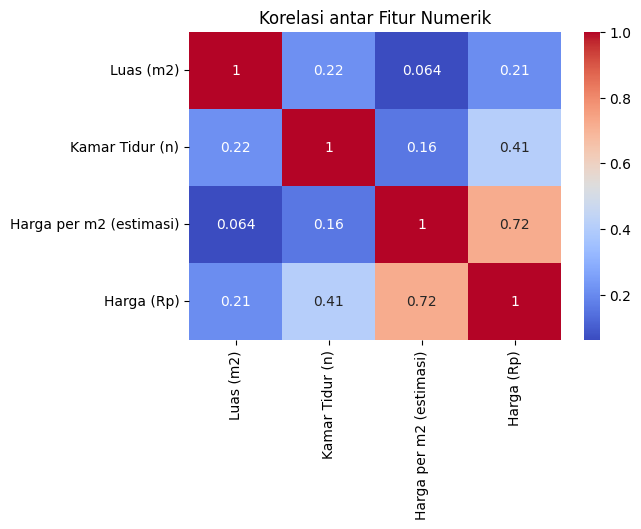

In [15]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Fitur Numerik')
plt.show()

**Insight**

- Harga per m² (estimasi) punya korelasi tertinggi terhadap Harga total (0.72) → faktor penentu utama harga apartemen.

- Jumlah kamar tidur berkorelasi sedang (0.41) → berpengaruh tapi tidak dominan.

- Luas (m²) korelasinya rendah (0.21) → tidak cukup kuat menjelaskan harga tanpa mempertimbangkan lokasi atau harga per m².

- Fitur harga per m² lebih representatif daripada luas atau jumlah kamar dalam memprediksi harga.

**Fitur & Target**

In [16]:
features = [
    'Luas (m2)', 'Kamar Tidur (n)', 'Harga per m2 (estimasi)',
    'Kelurahan_Freq', 'Kecamatan_Freq', 'Kota_Freq', 'Hak Guna_Freq'
]
target = 'Harga (Rp)'

X = df[features]
y = df[target]

**Insight**

Menyiapkan data sebelum melatih model Machine Learning untuk memprediksi harga apartemen (Harga (Rp)).

**Data Splitting**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan jumlah sampel
print(f'Total jumlah sampel: {len(X)}')
print(f'Jumlah data latih  : {len(X_train)}')
print(f'Jumlah data uji    : {len(X_test)}')

Total jumlah sampel: 2191
Jumlah data latih  : 1752
Jumlah data uji    : 439


**Insight**

Dataset dibagi menjadi data latih dan data uji dengan rasio 80:20 menggunakan train_test_split.

- Total sampel : 2191
- Data latih   : 1752 (80%)
- Data uji     : 439 (20%)

### Model Training & Evaluation

In [18]:
# Inisialisasi model
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
dt_model = DecisionTreeRegressor(random_state=42)

# Latih model
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Prediksi
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
dt_pred = dt_model.predict(X_test)

**Insight**

Model regresi yang diterapkan dalam analisis ini meliputi Random Forest, Gradient Boosting, dan Decision Tree.

In [19]:
# Evaluasi fungsi
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print("-" * len(name))
    print(f"MAE      : {int(mae):,}".replace(",", "."))
    print(f"MSE      : {int(mse):,}".replace(",", "."))
    print(f"RMSE     : {int(rmse):,}".replace(",", "."))
    print(f"R-Squared: {r2:.4f}")

# Evaluasi model
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("Decision Tree", y_test, dt_pred)
evaluate_model("Gradient Boosting", y_test, gb_pred)


Random Forest
-------------
MAE      : 734.432.949
MSE      : 17.795.225.319.368.050.688
RMSE     : 4.218.438.730
R-Squared: 0.9715

Decision Tree
-------------
MAE      : 1.161.969.248
MSE      : 23.434.475.212.414.578.688
RMSE     : 4.840.916.773
R-Squared: 0.9625

Gradient Boosting
-----------------
MAE      : 1.234.944.817
MSE      : 15.181.302.193.180.223.488
RMSE     : 3.896.319.056
R-Squared: 0.9757


**Insight**

- Random Forest juga cukup baik:
  - R-Squared tinggi (0.9715)
  - MAE terendah (±734 juta) → kesalahan rata-rata terkecil, tapi RMSE-nya lebih tinggi dari Gradient Boosting.

- Decision Tree memiliki performa terendah:
  - R-Squared paling rendah (0.9625)
  - RMSE paling tinggi (±4.84 M) → prediksi cenderung lebih kasar dan rentan overfitting.

- Gradient Boosting memberikan performa terbaik secara keseluruhan:
  - R-Squared tertinggi (0.9757) → menjelaskan variasi harga paling baik.
  - RMSE terendah (±3.89 M) → prediksi paling akurat secara rata-rata.

### Model Tuning (GridSearchCV)

In [20]:
# Random Forest Regressor Tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("Best Random Forest Params:", rf_grid.best_params_)

# Decision Tree Regressor Tuning
dt_params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
print("Best Decision Tree Params:", dt_grid.best_params_)

# Gradient Boosting Regressor Tuning
gb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3, 5]
}
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
print("Best Gradient Boosting Params:", gb_grid.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Random Forest Params: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Decision Tree Params: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}


**Insight**

Untuk meningkatkan kinerja model, dilakukan penyesuaian hyperparameter menggunakan GridSearchCV pada ketiga algoritma berikut:

- Random Forest: Dilakukan eksplorasi kombinasi optimal dari parameter n_estimators, max_depth, dan min_samples_split.

- Decision Tree: Proses tuning difokuskan pada parameter max_depth dan min_samples_split.

- Gradient Boosting: Dicoba berbagai konfigurasi n_estimators, max_depth, dan learning_rate untuk mendapatkan performa terbaik.

Setiap pencarian menggunakan cross-validation sebanyak 3 fold dan dievaluasi menggunakan metrik negative Mean Absolute Error (MAE). Model terbaik dari masing-masing pencarian disimpan sebagai estimator akhir (best_rf, best_dt, dan best_gb) yang akan digunakan untuk proses prediksi dan evaluasi selanjutnya.

In [21]:
# Fungsi evaluasi
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print(f"MAE      : {mae:,.0f}")
    print(f"MSE      : {mse:,.0f}")
    print(f"RMSE     : {rmse:,.0f}")
    print(f"R-Squared: {r2:.4f}")

# Prediksi
best_rf_pred = best_rf.predict(X_test)
best_dt_pred = best_dt.predict(X_test)
best_gb_pred = best_gb.predict(X_test)

# Evaluasi model yang sudah dituning
evaluate_model("Random Forest (Tuned)", y_test, best_rf_pred)
evaluate_model("Decision Tree (Tuned)", y_test, best_dt_pred)
evaluate_model("Gradient Boosting (Tuned)", y_test, best_gb_pred)

# Tampilkan parameter terbaik
print("\nBest Hyperparameters:")
print("Best Random Forest Params      :", rf_grid.best_params_)
print("Best Decision Tree Params      :", dt_grid.best_params_)
print("Best Gradient Boosting Params  :", gb_grid.best_params_)


Random Forest (Tuned)
MAE      : 721,409,372
MSE      : 17,042,014,454,308,581,376
RMSE     : 4,128,197,482
R-Squared: 0.9727

Decision Tree (Tuned)
MAE      : 1,077,433,723
MSE      : 19,970,412,670,443,679,744
RMSE     : 4,468,826,767
R-Squared: 0.9680

Gradient Boosting (Tuned)
MAE      : 582,910,206
MSE      : 8,871,530,371,283,419,136
RMSE     : 2,978,511,435
R-Squared: 0.9858

Best Hyperparameters:
Best Random Forest Params      : {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Decision Tree Params      : {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Gradient Boosting Params  : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}


**Insight**

- Gradient Boosting (Tuned)
  - MAE: Rp 582,9 juta (terendah)

  - RMSE: Rp 2,97 miliar (terendah)

  - R²: 0,9858 (tertinggi)

  - Parameter: learning_rate=0.1, max_depth=5, min_samples_split=5, min_samples_leaf=1, n_estimators=300, subsample=0.8

  Model terbaik secara keseluruhan. Memberikan prediksi yang sangat presisi dan mampu menjelaskan hampir seluruh variasi harga apartemen. Cocok digunakan sebagai model final karena performa dan stabilitasnya.

- Random Forest (Tuned)
  - MAE: Rp 721,4 juta

  - RMSE: Rp 4,13 miliar

  - R²: 0,9727

  - Parameter: max_depth=20, min_samples_split=2, min_samples_leaf=1, n_estimators=300, bootstrap=True

  Performa sangat baik, hanya sedikit di bawah Gradient Boosting. Model ini cenderung lebih stabil dan tahan terhadap overfitting dibanding Decision Tree, menjadikannya alternatif yang solid.

- Decision Tree (Tuned)
  - MAE: Rp 1,07 miliar (tertinggi)

  - RMSE: Rp 4,47 miliar

  - R²: 0,9680 (terendah)

  - Parameter: max_depth=15, min_samples_split=2, min_samples_leaf=1

  Model dengan performa paling rendah di antara ketiganya. Meskipun lebih sederhana dan cepat, Decision Tree rentan terhadap overfitting dan kurang mampu menangkap pola kompleks dalam data properti.





In [22]:
# Perbandingan MAE dan R2 Sebelum vs Sesudah Tuning
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'GradientBoosting'],
    'MAE Default': [
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, dt_pred),
        mean_absolute_error(y_test, gb_pred),
    ],
    'MAE Tuned': [
        mean_absolute_error(y_test, best_rf_pred),
        mean_absolute_error(y_test, best_dt_pred),
        mean_absolute_error(y_test, best_gb_pred)
    ],
    'R2 Default': [
        r2_score(y_test, rf_pred),
        r2_score(y_test, dt_pred),
        r2_score(y_test, gb_pred)
    ],
    'R2 Tuned': [
        r2_score(y_test, best_rf_pred),
        r2_score(y_test, best_dt_pred),
        r2_score(y_test, best_gb_pred)
    ],
})

model_comparison[['MAE Default', 'MAE Tuned']] = model_comparison[
    ['MAE Default', 'MAE Tuned']
].applymap(lambda x: f"{int(x):,}".replace(",", "."))

model_comparison

<ipython-input-22-f8bc50c07fe3>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ].applymap(lambda x: f"{int(x):,}".replace(",", "."))


,Model,MAE Default,MAE Tuned,R2 Default,R2 Tuned
0,Random Forest,734.432.949,721.409.371,0.971488,0.972695
1,Decision Tree,1.161.969.248,1.077.433.722,0.962453,0.968003
2,GradientBoosting,1.234.944.817,582.910.206,0.975676,0.985786


**Insight**

- Gradient Boosting adalah model terbaik setelah tuning.
  - MAE turun drastis dari 1,23 Miliar ke 582 Juta.
  - R² meningkat signifikan dari 0.9757 menjadi 0.9858, yang berarti model menjelaskan 98.6% variasi harga apartemen.

- Random Forest memiliki kinerja stabil namun peningkatan kecil setelah tuning.
  - MAE turun tipis dari 734 Juta ke 721 Juta.
  - R² hanya naik dari 0.9715 ke 0.9727, jadi tuning tidak memberikan lonjakan besar.

- Decision Tree mengalami perbaikan sedang.
  - MAE menurun sekitar 84 Juta.
  - R² naik dari 0.9625 ke 0.9680, menunjukkan tuning memberikan dampak moderat terhadap model ini.

In [23]:
# Perbandingan MSE Train dan Test
mse_df = pd.DataFrame(columns=['Train MSE', 'Test MSE'],
                      index=['Random Forest', 'Decision Tree', 'GradientBoosting'])

model_dict = {
    'Random Forest': best_rf,
    'Decision Tree': best_dt,
    'GradientBoosting': best_gb,
}

for name, model in model_dict.items():
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, model.predict(X_test))
    mse_df.loc[name] = [train_mse, test_mse]

mse_df

,Train MSE,Test MSE
Random Forest,2152783606421215488.0,17042014454308581376.0
Decision Tree,1440331480627756.5,19970412670443679744.0
GradientBoosting,8992683226272060.0,8871530371283419136.0


**Insight**

- Random Forest
   * Train MSE sangat tinggi (\~2.15e18) dan Test MSE juga makin tinggi (\~1.7e19).
   * MSE test jauh lebih tinggi dari train, menandakan kemungkinan **overfitting**.
   * Namun, Train MSE juga sangat besar, mungkin ada masalah dengan skala data atau target sangat besar.

- Decision Tree
   * Train MSE lebih kecil dibanding RF (\~1.44e15), tapi Test MSE jauh melonjak (\~1.99e19).
   * Ini indikasi **overfitting yang sangat parah**: model sangat pas di data train tapi gagal generalisasi.

- Gradient Boosting

   * Train MSE di skala 8.99e15, Test MSE juga cukup besar tapi lebih kecil dari yang lain (\~8.87e18).
   * Lebih baik dibanding dua model lain untuk test set, tapi masih sangat tinggi.
   * Mungkin model ini yang paling stabil di antara ketiganya.

In [24]:
# Prediksi Sample
prediksi = X_test.iloc[5:10].copy()
pred_dict = {'Harga Asli': y_test.iloc[5:10]}

for name, model in model_dict.items():
    pred_dict[name] = model.predict(prediksi).round(1)

hasil_prediksi = pd.DataFrame(pred_dict)

hasil_prediksi

,Harga Asli,Random Forest,Decision Tree,GradientBoosting
1975,1.400000e+10,1.401667e+10,1.400000e+10,1.402682e+10
363,1.600000e+10,1.634333e+10,1.600000e+10,1.591025e+10
284,4.400000e+10,4.443333e+10,4.500000e+10,4.458434e+10
168,2.700000e+08,2.673933e+08,2.700000e+08,2.578264e+08
100,1.200000e+10,1.415000e+10,1.400000e+10,1.317739e+10


**Insight**

- Random Forest adalah model paling stabil dan akurat dari segi nilai prediksi pada kasus ini.

- Decision Tree terlalu keras dan overfit, cenderung mem-predict ke nilai tetap.

- Gradient Boosting menunjukkan kemampuan generalisasi yang lebih halus, tapi sedikit kalah presisi dibanding Random Forest.